In [2]:
import torch

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using Device = {torch.get_default_device()}")

Using Device = cpu


In [3]:
import pandas as pd

totalcattle = pd.read_csv("Data/TotalCattle.csv")
janind = totalcattle['Period']=="FIRST OF JAN"
JanData = totalcattle[['Year','Value']][janind].sort_index(ascending=False).reset_index()
CattleData = JanData['Value'].str.replace(',','').astype(int)
YearData = JanData['Year']

In [4]:
JanData.head()

,index,Year,Value
0,208,1867,"28,636,000"
1,207,1868,"29,238,000"
2,206,1869,"30,060,000"
3,205,1870,"31,082,000"
4,204,1871,"32,107,000"


In [5]:
CattleData

0      28636000
1      29238000
2      30060000
3      31082000
4      32107000
         ...   
154    93586500
155    91788700
156    88841000
157    87157400
158    86662200
Name: Value, Length: 159, dtype: int64

<Axes: >

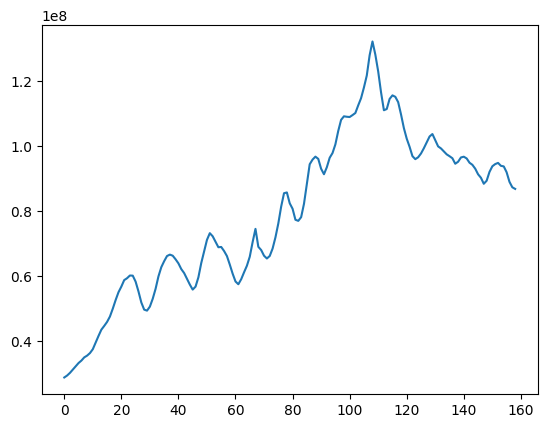

In [6]:
train_size = int(len(CattleData) * 0.8)
CattleData.plot()
#plt.plot(JanData[:train_size]['Year'].tolist(),JanData[:train_size]['Value'].tolist())

In [7]:
YearData[train_size:]

127    1994
128    1995
129    1996
130    1997
131    1998
132    1999
133    2000
134    2001
135    2002
136    2003
137    2004
138    2005
139    2006
140    2007
141    2008
142    2009
143    2010
144    2011
145    2012
146    2013
147    2014
148    2015
149    2016
150    2017
151    2018
152    2019
153    2020
154    2021
155    2022
156    2023
157    2024
158    2025
Name: Year, dtype: int64

In [8]:
import matplotlib.pyplot as plt

train_size = int(len(CattleData) * 0.8)

train_data = CattleData[:train_size]
test_data = CattleData[train_size:]

Train_years = YearData[:train_size]
Test_years = YearData[train_size:]


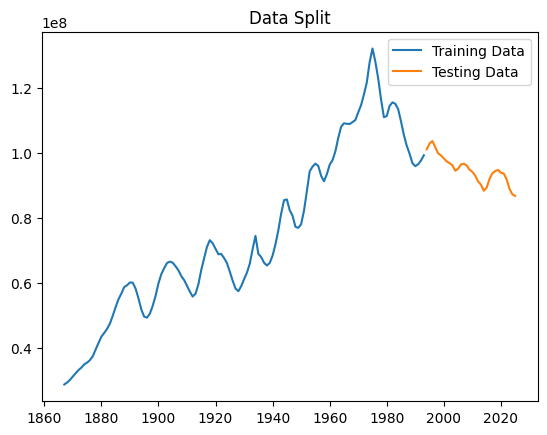

In [9]:
plt.figure()
plt.plot(Train_years,train_data.tolist(), label="Training Data")
plt.plot(Test_years,test_data.tolist(), label="Testing Data")
plt.title("Data Split")
plt.legend()
plt.show()

In [10]:
from torch.utils.data import Dataset
import numpy as np

class CattleDataset(Dataset):
    def __init__(self, data, seq_length=5, pred_length=1):
        self.data = data
        self.seq_length = seq_length
        self.pred_length = pred_length

        self.mean = np.mean(data)
        self.std = np.std(data)
        self.data_norm = (data - self.mean) / self.std
    
    def __len__(self):
        return len(self.data) - self.seq_length - self.pred_length + 1
    
    def __getitem__(self, idx):
        x = self.data_norm[idx:idx + self.seq_length].reset_index(drop=True)
        y = self.data_norm[idx + self.seq_length:idx + self.seq_length + self.pred_length].reset_index(drop=True)

        x_tensor = torch.FloatTensor(x).unsqueeze(-1)
        y_tensor = torch.FloatTensor(y)

        return x_tensor, y_tensor


In [11]:
# train_size = int(len(CattleData) * 0.8)
# train_data = CattleData[:train_size]
# test_data = CattleData[train_size:]
from torch.utils.data import DataLoader

seq_length = 20
pred_length = 1

train_set = CattleDataset(train_data,seq_length,pred_length)
test_set = CattleDataset(test_data,seq_length,pred_length)

train_dataloader = DataLoader(train_set, batch_size=10, shuffle=True)
test_dataloader  = DataLoader(test_set,  batch_size=10, shuffle=False)


In [12]:
ys = []
xs = []
iss=0
for i, (x,y) in enumerate(test_dataloader):
    iss+=1
    xs.append(x)
    ys.append(y)


In [30]:
xs[1].shape

torch.Size([2, 20, 1])

In [20]:
xs[0].shape

torch.Size([10, 20, 1])

In [77]:
listys = []
for i in ys[0].tolist()+ys[1].tolist():
    listys.append(i[0])
listys

[-1.5031172037124634,
 -1.2874082326889038,
 -0.657677412033081,
 -0.2548815608024597,
 -0.0986897349357605,
 -0.01363547146320343,
 -0.2215510457754135,
 -0.2637186646461487,
 -0.6807095408439636,
 -1.364414095878601,
 -1.754916787147522,
 -1.8697760105133057]

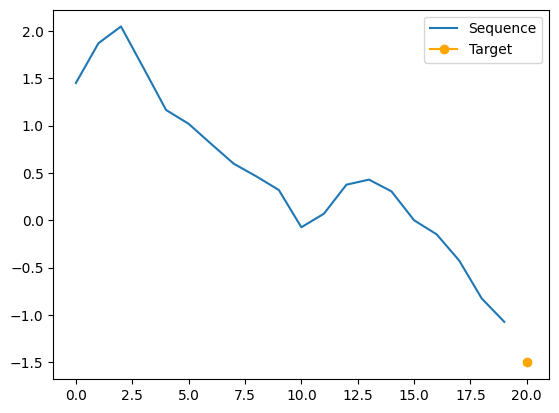

In [68]:
batchnum = 0
sequenum = 0

listxs = []
for i in xs[batchnum][sequenum].tolist():
    listxs.append(i[0])

singy=ys[batchnum][sequenum]

dom = range(len(listxs))

plt.figure()
plt.plot(dom,listxs,label="Sequence")
plt.plot(len(listxs),singy,color="Orange",label="Target",marker="o")
plt.legend()
plt.show()

In [23]:
import torch.nn as nn

# class CattleLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(CattleLSTM, self).__init__()

#         self.lstm = nn.LSTM(input_size,hidden_size,batch_first=True)
#         self.h2o = nn.Linear(hidden_size, output_size)
#         self.softmax = nn.LogSoftmax(dim=1)
    
#     def forward(self,line_tensor):
#         lstm_out, hidden = self.lstm(line_tensor)
#         output = self.h2o(hidden[0][-1])
#         output = self.softmax(output)

#         return output

class CattleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        _, (h_n, _) = self.lstm(x)

        # last layer hidden state
        h_last = h_n[-1]           # (batch, hidden_size)
        out = self.fc(h_last)      # (batch, output_size)

        return out


In [24]:
#X, y = next(iter(train_dataloader))

In [25]:
#y

In [26]:
n_hidden = 20

lstm = CattleLSTM(input_size=1,hidden_size=n_hidden,output_size=pred_length)

In [27]:
#pred = lstm(X)

In [28]:
#pred

In [29]:
testlin = nn.Linear(10,1)


In [30]:
import time

learning_rate = 1e-3
batch_size = 64
epochs = 5

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # all_losses = []
    model.train()


    for batch, (X,y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred,y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # all_losses.append(loss.item())

        if batch % 5 == 0:
            loss, current = loss.item(), batch * batch_size
            print(f"Loss: {loss:>7f}    [{current:<5d}/{size:>5d}]")
    
    # return all_losses
      
    


In [31]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X,y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    
    test_loss /= num_batches
    print(f"Test Error: \n Avg Loss: {test_loss:>8f}")
            

In [32]:
X, y = next(iter(train_dataloader))
print(X.shape, y.shape)

torch.Size([10, 20, 1]) torch.Size([10, 1])


In [33]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, lstm, loss_fn, optimizer)
    test_loop(test_dataloader, lstm, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Loss: 1.389068    [0    /  107]
Loss: 0.646874    [320  /  107]
Loss: 0.423568    [640  /  107]
Test Error: 
 Avg Loss: 2.037439
Epoch 2
-------------------------------
Loss: 0.759399    [0    /  107]
Loss: 1.107451    [320  /  107]
Loss: 0.538077    [640  /  107]
Test Error: 
 Avg Loss: 2.024240
Epoch 3
-------------------------------
Loss: 0.450794    [0    /  107]
Loss: 0.649836    [320  /  107]
Loss: 0.632488    [640  /  107]
Test Error: 
 Avg Loss: 2.010600
Epoch 4
-------------------------------
Loss: 0.853857    [0    /  107]
Loss: 0.436787    [320  /  107]
Loss: 0.383801    [640  /  107]
Test Error: 
 Avg Loss: 1.975118
Epoch 5
-------------------------------
Loss: 0.369856    [0    /  107]
Loss: 0.438839    [320  /  107]
Loss: 0.552985    [640  /  107]
Test Error: 
 Avg Loss: 1.951467
Epoch 6
-------------------------------
Loss: 0.247722    [0    /  107]
Loss: 0.187545    [320  /  107]
Loss: 0.135478    [640  /  107]
Test Error: 
 Avg L

In [34]:
def plotting(dataloader, model):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0
    preds=[]
    actu=[]

    with torch.no_grad():
        for X,y in dataloader:
            pred=model(X)
            preds+=pred.tolist()
            print(preds)
            actu+=y.tolist()
            
    return preds, actu

In [35]:
Fpred, actu = plotting(test_dataloader,lstm)

[[1.0067775249481201], [0.8577583432197571], [0.6907874941825867], [0.5174939632415771], [0.3092799484729767], [0.08386874198913574], [-0.10245293378829956], [-0.207701176404953], [-0.2512872815132141], [-0.2945624589920044]]
[[1.0067775249481201], [0.8577583432197571], [0.6907874941825867], [0.5174939632415771], [0.3092799484729767], [0.08386874198913574], [-0.10245293378829956], [-0.207701176404953], [-0.2512872815132141], [-0.2945624589920044], [-0.3546598553657532], [-0.40895944833755493]]


In [36]:
Fpred

[[1.0067775249481201],
 [0.8577583432197571],
 [0.6907874941825867],
 [0.5174939632415771],
 [0.3092799484729767],
 [0.08386874198913574],
 [-0.10245293378829956],
 [-0.207701176404953],
 [-0.2512872815132141],
 [-0.2945624589920044],
 [-0.3546598553657532],
 [-0.40895944833755493]]

In [37]:
results = []
for i in Fpred:
    results.append(i[0])
results

[1.0067775249481201,
 0.8577583432197571,
 0.6907874941825867,
 0.5174939632415771,
 0.3092799484729767,
 0.08386874198913574,
 -0.10245293378829956,
 -0.207701176404953,
 -0.2512872815132141,
 -0.2945624589920044,
 -0.3546598553657532,
 -0.40895944833755493]

In [38]:
vals = []
for i in actu:
    vals.append(i[0])
vals

[-1.5031172037124634,
 -1.2874082326889038,
 -0.657677412033081,
 -0.2548815608024597,
 -0.0986897349357605,
 -0.01363547146320343,
 -0.2215510457754135,
 -0.2637186646461487,
 -0.6807095408439636,
 -1.364414095878601,
 -1.754916787147522,
 -1.8697760105133057]

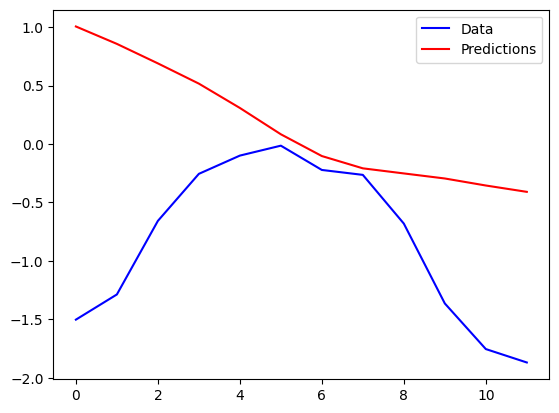

In [39]:

xs = range(len(vals))
plt.plot(xs,vals,color="Blue",label="Data")
plt.plot(xs,results,color="red",label="Predictions")
plt.legend()
plt.show()

In [47]:
len(results)

12

ValueError: x and y must have same first dimension, but have shapes (32,) and (12,)

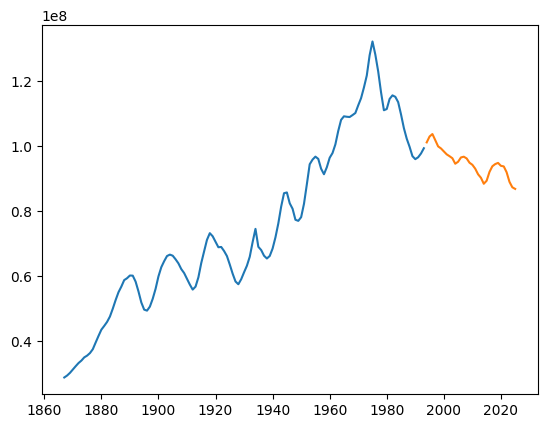

In [40]:
plt.figure()
plt.plot(Train_years,train_data.tolist(), label="Training Data")
plt.plot(Test_years,test_data.tolist(), label="Testing Data")
plt.plot(Test_years,results,color="orange",label="Predictions")
plt.title("Data Split")
plt.legend()
plt.show()